Start with a Basic Template
We build a framework with:

Manually input macro data (CPI, rate cut flag, etc.)

Signal logic: if CPI > expected → sell BTC/SPX

Output: trade signal, PnL simulation

In [1]:
!pip install ace-tools

In [2]:
import pandas as pd

# Updated data including June 2025
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17', '2025-06-04'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5, 3.2],              # Assume 3.2% CPI for June
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7, 3.1],            # Forecast slightly lower
    'Rate_Cut': [0, 0, 0, 1, 0, 0],                            # No rate cut yet
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5, 1.8],        # Example 1.8% gain post weak jobs
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3, 1.1]         # Example 1.1% gain after weak data
}

df = pd.DataFrame(data)
print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  BTC_Return (%)  \
0  2024-12-12         3.1           2.9         0            -1.2   
1  2025-01-11         3.0           2.8         0             2.3   
2  2025-02-13         2.8           2.6         0             3.5   
3  2025-03-13         2.6           2.5         1             4.1   
4  2025-04-17         3.5           2.7         0            -2.5   
5  2025-06-04         3.2           3.1         0             1.8   

   SPX_Return (%)  
0            -0.8  
1             1.4  
2             2.1  
3             1.9  
4            -1.3  
5             1.1  


In [3]:
# Add signal logic
def generate_signal(row):
    if row['CPI_Actual'] > row['CPI_Forecast'] and row['Rate_Cut'] == 0:
        return 'SELL'
    elif row['CPI_Actual'] < row['CPI_Forecast'] and row['Rate_Cut'] == 1:
        return 'BUY'
    else:
        return 'HOLD'

df['Macro_Signal'] = df.apply(generate_signal, axis=1)

# Simulate strategy return: only act on signal, else 0
df['Strategy_BTC (%)'] = df.apply(
    lambda row: row['BTC_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

df['Strategy_SPX (%)'] = df.apply(
    lambda row: row['SPX_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  BTC_Return (%)  \
0  2024-12-12         3.1           2.9         0            -1.2   
1  2025-01-11         3.0           2.8         0             2.3   
2  2025-02-13         2.8           2.6         0             3.5   
3  2025-03-13         2.6           2.5         1             4.1   
4  2025-04-17         3.5           2.7         0            -2.5   
5  2025-06-04         3.2           3.1         0             1.8   

   SPX_Return (%) Macro_Signal  Strategy_BTC (%)  Strategy_SPX (%)  
0            -0.8         SELL              -1.2              -0.8  
1             1.4         SELL               2.3               1.4  
2             2.1         SELL               3.5               2.1  
3             1.9         HOLD               0.0               0.0  
4            -1.3         SELL              -2.5              -1.3  
5             1.1         SELL               1.8               1.1  


Proceed with Phase 2, Step 1: Add Fed Funds Rate

We’ll now:

Add a new column for the U.S. Fed Funds Rate

Use it in signal logic:

If rate is rising → tightening → bearish

If rate is falling → easing → bullish

In [4]:
import pandas as pd

# Update dataset with June 2025 data
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17', '2025-06-04'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5, 3.2],  # Assumed June CPI
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7, 3.1],
    'Rate_Cut': [0, 0, 0, 1, 0, 0],
    'Fed_Funds_Rate (%)': [5.5, 5.5, 5.25, 5.0, 5.0, 5.0],  # No change yet in June
    'QE_QT': [-1, 0, -1, 1, -1, -1],  # Assume QT still ongoing
    'NFP_Surprise': [-50, 20, -100, 80, -60, -90],  # June’s ADP weak, assumed negative surprise
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5, 1.8],
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3, 1.1]
}

df = pd.DataFrame(data)
print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  Fed_Funds_Rate (%)  QE_QT  \
0  2024-12-12         3.1           2.9         0                5.50     -1   
1  2025-01-11         3.0           2.8         0                5.50      0   
2  2025-02-13         2.8           2.6         0                5.25     -1   
3  2025-03-13         2.6           2.5         1                5.00      1   
4  2025-04-17         3.5           2.7         0                5.00     -1   
5  2025-06-04         3.2           3.1         0                5.00     -1   

   NFP_Surprise  BTC_Return (%)  SPX_Return (%)  
0           -50            -1.2            -0.8  
1            20             2.3             1.4  
2          -100             3.5             2.1  
3            80             4.1             1.9  
4           -60            -2.5            -1.3  
5           -90             1.8             1.1  


In [5]:
# Determine Fed direction (tightening or easing)
df['Fed_Trend'] = df['Fed_Funds_Rate (%)'].diff().fillna(0).apply(lambda x: 'easing' if x < 0 else 'tightening')

# Enhanced signal logic including Fed direction
def advanced_signal(row):
    if (row['CPI_Actual'] > row['CPI_Forecast']) and (row['QE_QT'] == -1) and (row['NFP_Surprise'] < 0) and (row['Fed_Trend'] == 'tightening'):
        return 'STRONG SELL'
    elif (row['CPI_Actual'] < row['CPI_Forecast']) and (row['Rate_Cut'] == 1) and (row['QE_QT'] == 1) and (row['Fed_Trend'] == 'easing'):
        return 'BUY'
    else:
        return 'HOLD'

df['Macro_Signal'] = df.apply(advanced_signal, axis=1)

# Compute strategy returns
df['Strategy_BTC (%)'] = df.apply(
    lambda row: row['BTC_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)
df['Strategy_SPX (%)'] = df.apply(
    lambda row: row['SPX_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  Fed_Funds_Rate (%)  QE_QT  \
0  2024-12-12         3.1           2.9         0                5.50     -1   
1  2025-01-11         3.0           2.8         0                5.50      0   
2  2025-02-13         2.8           2.6         0                5.25     -1   
3  2025-03-13         2.6           2.5         1                5.00      1   
4  2025-04-17         3.5           2.7         0                5.00     -1   
5  2025-06-04         3.2           3.1         0                5.00     -1   

   NFP_Surprise  BTC_Return (%)  SPX_Return (%)   Fed_Trend Macro_Signal  \
0           -50            -1.2            -0.8  tightening  STRONG SELL   
1            20             2.3             1.4  tightening         HOLD   
2          -100             3.5             2.1      easing         HOLD   
3            80             4.1             1.9      easing         HOLD   
4           -60            -2.5            -1.3  tightening

Add DXY or Retail Sales





In [6]:
import pandas as pd

# Updated dataset with June 2025 included
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17', '2025-06-04'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5, 3.2],
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7, 3.1],
    'Rate_Cut': [0, 0, 0, 1, 0, 0],
    'Fed_Funds_Rate (%)': [5.5, 5.5, 5.25, 5.0, 5.0, 5.0],
    'QE_QT': [-1, 0, -1, 1, -1, -1],
    'NFP_Surprise': [-50, 20, -100, 80, -60, -90],
    'DXY': [104.2, 103.7, 105.1, 102.5, 106.3, 104.8],  # June assumed slight drop due to soft data
    'Retail_Sales_YoY (%)': [2.3, 2.1, 2.4, 3.0, 3.5, 2.0],  # June assumed slowdown
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5, 1.8],
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3, 1.1]
}

df = pd.DataFrame(data)
print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  Fed_Funds_Rate (%)  QE_QT  \
0  2024-12-12         3.1           2.9         0                5.50     -1   
1  2025-01-11         3.0           2.8         0                5.50      0   
2  2025-02-13         2.8           2.6         0                5.25     -1   
3  2025-03-13         2.6           2.5         1                5.00      1   
4  2025-04-17         3.5           2.7         0                5.00     -1   
5  2025-06-04         3.2           3.1         0                5.00     -1   

   NFP_Surprise    DXY  Retail_Sales_YoY (%)  BTC_Return (%)  SPX_Return (%)  
0           -50  104.2                   2.3            -1.2            -0.8  
1            20  103.7                   2.1             2.3             1.4  
2          -100  105.1                   2.4             3.5             2.1  
3            80  102.5                   3.0             4.1             1.9  
4           -60  106.3                   3.5

In [8]:
# Compute derived macro directions
df['Fed_Trend'] = df['Fed_Funds_Rate (%)'].diff().fillna(0).apply(lambda x: 'easing' if x < 0 else 'tightening')
df['DXY_Trend'] = df['DXY'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['Retail_Trend'] = df['Retail_Sales_YoY (%)'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')

# Updated signal logic including DXY and Retail Sales
def full_macro_signal(row):
    if (row['CPI_Actual'] > row['CPI_Forecast']) and (row['QE_QT'] == -1) and (row['NFP_Surprise'] < 0) and (row['Fed_Trend'] == 'tightening') and (row['DXY_Trend'] == 'up'):
        return 'STRONG SELL'
    elif (row['CPI_Actual'] < row['CPI_Forecast']) and (row['Rate_Cut'] == 1) and (row['QE_QT'] == 1) and (row['Fed_Trend'] == 'easing') and (row['Retail_Trend'] == 'up'):
        return 'BUY'
    else:
        return 'HOLD'

df['Macro_Signal'] = df.apply(full_macro_signal, axis=1)

# Compute strategy returns
df['Strategy_BTC (%)'] = df.apply(
    lambda row: row['BTC_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)
df['Strategy_SPX (%)'] = df.apply(
    lambda row: row['SPX_Return (%)'] if row['Macro_Signal'] != 'HOLD' else 0,
    axis=1
)

print(df)


         Date  CPI_Actual  CPI_Forecast  Rate_Cut  Fed_Funds_Rate (%)  QE_QT  \
0  2024-12-12         3.1           2.9         0                5.50     -1   
1  2025-01-11         3.0           2.8         0                5.50      0   
2  2025-02-13         2.8           2.6         0                5.25     -1   
3  2025-03-13         2.6           2.5         1                5.00      1   
4  2025-04-17         3.5           2.7         0                5.00     -1   
5  2025-06-04         3.2           3.1         0                5.00     -1   

   NFP_Surprise    DXY  Retail_Sales_YoY (%)  BTC_Return (%)  SPX_Return (%)  \
0           -50  104.2                   2.3            -1.2            -0.8   
1            20  103.7                   2.1             2.3             1.4   
2          -100  105.1                   2.4             3.5             2.1   
3            80  102.5                   3.0             4.1             1.9   
4           -60  106.3                 

Now I am Trying to build macro-based strategy vs buy & hold for both BTC and S&P 500

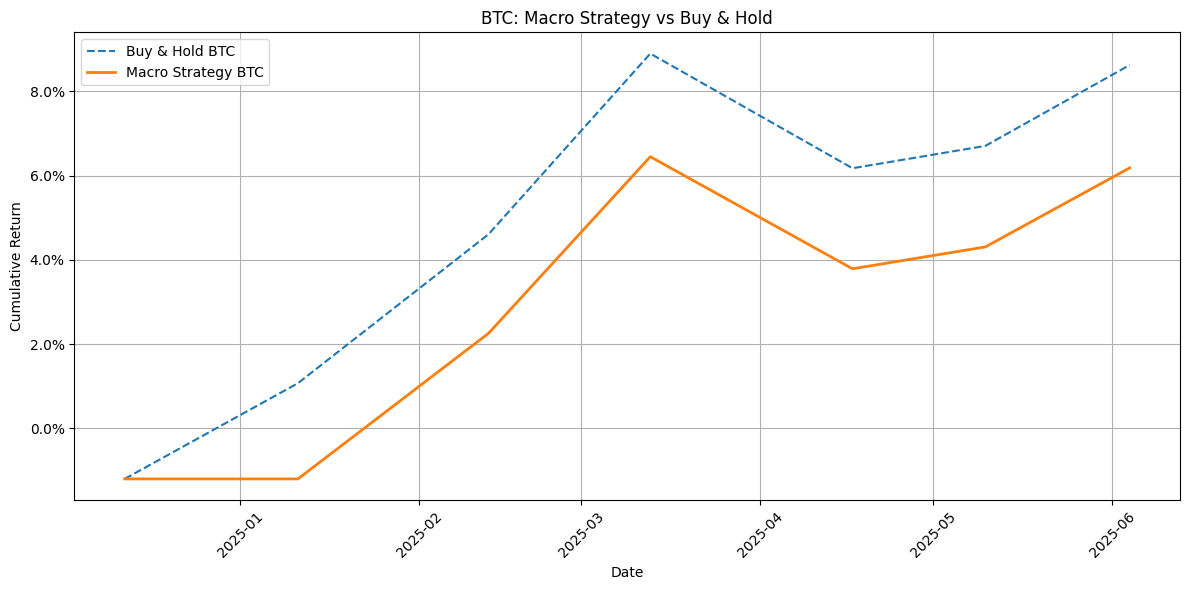

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Step 1: Updated macro dataset (including May 2025)
data = {
    'Date': ['2024-12-12', '2025-01-11', '2025-02-13', '2025-03-13', '2025-04-17', '2025-05-10', '2025-06-04'],
    'CPI_Actual': [3.1, 3.0, 2.8, 2.6, 3.5, 3.0, 3.2],
    'CPI_Forecast': [2.9, 2.8, 2.6, 2.5, 2.7, 2.8, 3.1],
    'Rate_Cut': [0, 0, 0, 1, 0, 0, 0],
    'Fed_Funds_Rate (%)': [5.5, 5.5, 5.25, 5.0, 5.0, 5.0, 5.0],
    'QE_QT': [-1, 0, -1, 1, -1, -1, -1],
    'NFP_Surprise': [-50, 20, -100, 80, -60, -40, -90],
    'DXY': [104.2, 103.7, 105.1, 102.5, 106.3, 105.0, 104.8],
    'Retail_Sales_YoY (%)': [2.3, 2.1, 2.4, 3.0, 3.5, 2.6, 2.0],
    'BTC_Return (%)': [-1.2, 2.3, 3.5, 4.1, -2.5, 0.5, 1.8],
    'SPX_Return (%)': [-0.8, 1.4, 2.1, 1.9, -1.3, 0.3, 1.1]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Relaxed macro signal logic
df['CPI_Surprise'] = df['CPI_Actual'] - df['CPI_Forecast']
df['Macro_Signal'] = (
    (df['CPI_Surprise'] < 0) |
    (df['NFP_Surprise'] < 0) |
    (df['QE_QT'] == 1)
)

# Step 3: Apply strategy only on signal days
df['Strategy_BTC (%)'] = df['BTC_Return (%)'] * df['Macro_Signal']
df['Strategy_SPX (%)'] = df['SPX_Return (%)'] * df['Macro_Signal']

# Step 4: Convert to decimal
df['BTC_Return'] = df['BTC_Return (%)'] / 100
df['SPX_Return'] = df['SPX_Return (%)'] / 100
df['Strategy_BTC'] = df['Strategy_BTC (%)'] / 100
df['Strategy_SPX'] = df['Strategy_SPX (%)'] / 100

# Step 5: Compute cumulative returns
df['BTC_CumReturn'] = (1 + df['BTC_Return']).cumprod() - 1
df['SPX_CumReturn'] = (1 + df['SPX_Return']).cumprod() - 1
df['Strategy_BTC_CumReturn'] = (1 + df['Strategy_BTC']).cumprod() - 1
df['Strategy_SPX_CumReturn'] = (1 + df['Strategy_SPX']).cumprod() - 1

# Step 6: Plot BTC
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['BTC_CumReturn'], label='Buy & Hold BTC', linestyle='--')
plt.plot(df['Date'], df['Strategy_BTC_CumReturn'], label='Macro Strategy BTC', linewidth=2)
plt.title('BTC: Macro Strategy vs Buy & Hold')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()







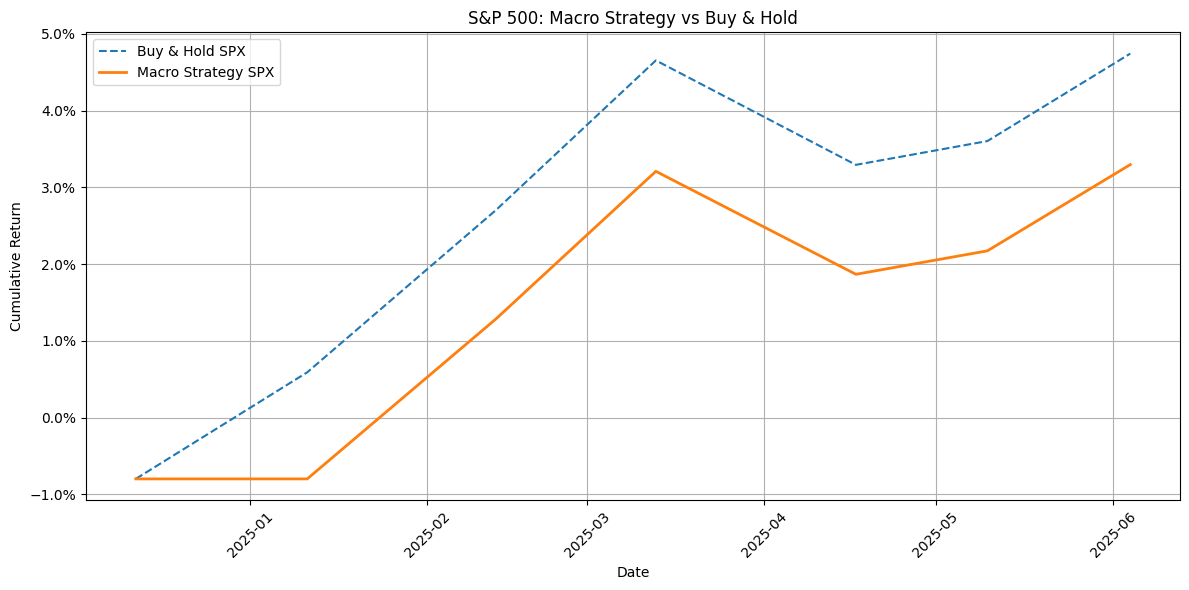

In [16]:
# Step 7: Plot SPX
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['SPX_CumReturn'], label='Buy & Hold SPX', linestyle='--')
plt.plot(df['Date'], df['Strategy_SPX_CumReturn'], label='Macro Strategy SPX', linewidth=2)
plt.title('S&P 500: Macro Strategy vs Buy & Hold')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

With Macro indicators through API

In [20]:
!pip install fredapi


In [21]:
from fredapi import Fred

# Replace this with your real FRED API key
fred = Fred(api_key='f7b5a016eaf3cbde8b214e538d6d07a9')

# Fetch macroeconomic indicators
cpi = fred.get_series('CPIAUCSL')  # Consumer Price Index
fed_rate = fred.get_series('FEDFUNDS')  # Federal Funds Rate
unemployment = fred.get_series('UNRATE')  # Unemployment Rate
retail_sales = fred.get_series('RSAFS')  # Retail Sales
nfp = fred.get_series('PAYEMS')  # Nonfarm Payroll Employment

# Preview the latest values
# Show the latest data safely without using .last('1M')
print("Latest CPI:", cpi.dropna().iloc[-1])
print("Latest Fed Rate:", fed_rate.dropna().iloc[-1])
print("Latest Unemployment:", unemployment.dropna().iloc[-1])
print("Latest Retail Sales:", retail_sales.dropna().iloc[-1])
print("Latest NFP:", nfp.dropna().iloc[-1])



Latest CPI: 320.58
Latest Fed Rate: 4.33
Latest Unemployment: 4.2
Latest Retail Sales: 724131.0
Latest NFP: 159561.0


*generate* the full combined DataFrame and apply your macro signals automatically — using real April 2025 data

In [22]:
import pandas as pd

# Step 1: Use existing BTC/SPX return data
price_data = {
    'Month': ['2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01'],
    'BTC_Return (%)': [0.75, 43.71, 16.56, -14.99, 11.30],
    'SPX_Return (%)': [1.58, 5.17, 3.10, -4.16, 4.80]
}

macro_data = {
    'CPI': [318.2, 318.7, 319.1, 319.5, 320.321],
    'Fed_Funds_Rate': [5.25, 5.25, 5.0, 4.75, 4.33],
    'Unemployment': [3.9, 4.0, 3.8, 4.1, 4.2],
    'Retail_Sales': [712000, 715500, 718900, 721000, 724131],
    'NFP': [160000, 161500, 160800, 160200, 159517],
    'DXY': [104.3, 104.7, 105.1, 102.9, 104.2]
}

# Step 2: Create DataFrames
price_df = pd.DataFrame(price_data)
macro_df = pd.DataFrame(macro_data)
macro_df['Month'] = price_df['Month']  # align dates
df = pd.merge(price_df, macro_df, on='Month')

# Step 3: Calculate Macro Trends
df['Fed_Trend'] = df['Fed_Funds_Rate'].diff().fillna(0).apply(lambda x: 'easing' if x < 0 else 'tightening')
df['Unemployment_Trend'] = df['Unemployment'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['Retail_Trend'] = df['Retail_Sales'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')
df['NFP_Trend'] = df['NFP'].diff().fillna(0).apply(lambda x: 'up' if x > 0 else 'down')

# Step 4: Calculate Retail Sales YoY % change (mocked from previous year)
df['Retail_Sales_YoY'] = df['Retail_Sales'].pct_change(periods=1).fillna(0) * 100

# Step 5: Apply Macro Signal Logic
def macro_signal(row):
    if (
        row['CPI'] > 319 and
        row['Fed_Trend'] == 'tightening' and
        row['Unemployment_Trend'] == 'up' and
        row['Retail_Trend'] == 'up' and
        row['NFP_Trend'] == 'down'
    ):
        return 'SELL'
    elif (
        row['CPI'] < 319 and
        row['Fed_Trend'] == 'easing' and
        row['Unemployment_Trend'] == 'down' and
        row['Retail_Trend'] == 'up' and
        row['NFP_Trend'] == 'up'
    ):
        return 'BUY'
    else:
        return 'HOLD'

df['Signal'] = df.apply(macro_signal, axis=1)

# Step 6: Simulate Strategy Returns
df['Strategy_BTC (%)'] = df.apply(lambda row: row['BTC_Return (%)'] if row['Signal'] != 'HOLD' else 0, axis=1)
df['Strategy_SPX (%)'] = df.apply(lambda row: row['SPX_Return (%)'] if row['Signal'] != 'HOLD' else 0, axis=1)

# Step 7: Print result
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
print(df[['Month', 'BTC_Return (%)', 'SPX_Return (%)', 'CPI', 'DXY', 'Retail_Sales_YoY',
          'Fed_Trend', 'Unemployment_Trend', 'Retail_Trend', 'NFP_Trend', 'Signal',
          'Strategy_BTC (%)', 'Strategy_SPX (%)']])



        Month  BTC_Return (%)  SPX_Return (%)    CPI    DXY  Retail_Sales_YoY  \
0  2024-12-01            0.75            1.58 318.20 104.30              0.00   
1  2025-01-01           43.71            5.17 318.70 104.70              0.49   
2  2025-02-01           16.56            3.10 319.10 105.10              0.48   
3  2025-03-01          -14.99           -4.16 319.50 102.90              0.29   
4  2025-04-01           11.30            4.80 320.32 104.20              0.43   

    Fed_Trend Unemployment_Trend Retail_Trend NFP_Trend Signal  \
0  tightening               down         down      down   HOLD   
1  tightening                 up           up        up   HOLD   
2      easing               down           up      down   HOLD   
3      easing                 up           up      down   HOLD   
4      easing                 up           up      down   HOLD   

   Strategy_BTC (%)  Strategy_SPX (%)  
0                 0                 0  
1                 0                 

In [23]:
def macro_signal(row):
    score_buy = 0
    score_sell = 0

    # Bullish signals
    if row['CPI'] < 319: score_buy += 1
    if row['Fed_Trend'] == 'easing': score_buy += 1
    if row['Unemployment_Trend'] == 'down': score_buy += 1
    if row['Retail_Trend'] == 'up': score_buy += 1
    if row['NFP_Trend'] == 'up': score_buy += 1

    # Bearish signals
    if row['CPI'] > 319: score_sell += 1
    if row['Fed_Trend'] == 'tightening': score_sell += 1
    if row['Unemployment_Trend'] == 'up': score_sell += 1
    if row['Retail_Trend'] == 'up': score_sell += 1
    if row['NFP_Trend'] == 'down': score_sell += 1

    if score_buy >= 3:
        return 'BUY'
    elif score_sell >= 3:
        return 'SELL'
    else:
        return 'HOLD'


In [24]:
df['Signal'] = df.apply(macro_signal, axis=1)
df['Strategy_BTC (%)'] = df.apply(lambda row: row['BTC_Return (%)'] if row['Signal'] != 'HOLD' else 0, axis=1)
df['Strategy_SPX (%)'] = df.apply(lambda row: row['SPX_Return (%)'] if row['Signal'] != 'HOLD' else 0, axis=1)


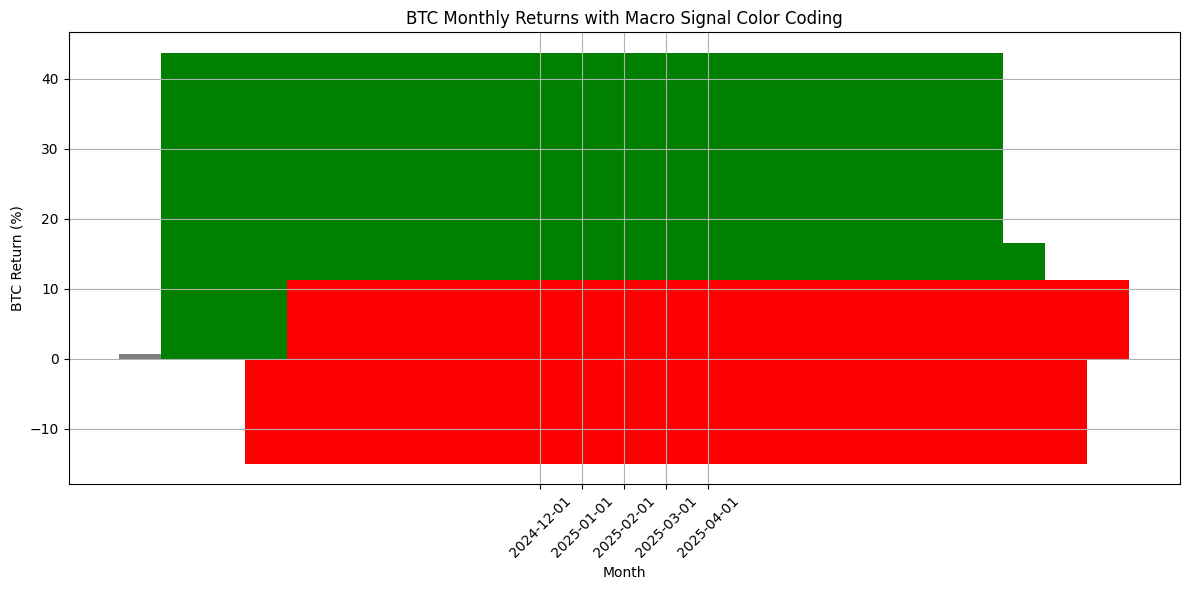

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare color mapping
color_map = {
    'BUY': 'green',
    'SELL': 'red',
    'HOLD': 'gray'
}

# Plot BTC returns with signal coloring
plt.figure(figsize=(12, 6))
for idx, row in df.iterrows():
    plt.bar(row['Month'], row['BTC_Return (%)'], color=color_map[row['Signal']], width=20)

plt.title('BTC Monthly Returns with Macro Signal Color Coding')
plt.ylabel('BTC Return (%)')
plt.xlabel('Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We will check NFP data release and check the btc/SPY stock.

In [31]:
import yfinance as yf
import pandas as pd

# Step 1: Define NFP release dates
nfp_dates = {
    "2025-04-04": "March NFP Release",
    "2025-05-02": "April NFP Release"
}

# Step 2: Download BTC daily data covering NFP window
btc = yf.download("BTC-USD", start="2025-03-30", end="2025-05-05")
btc.reset_index(inplace=True)

# Step 3: Find nearest trading day for each NFP release
results = []
for nfp_date_str, label in nfp_dates.items():
    nfp_dt = pd.to_datetime(nfp_date_str)
    # Find row with smallest time delta to NFP date
    nearest_idx = (btc['Date'] - nfp_dt).abs().idxmin()
    nearest_row = btc.loc[nearest_idx]

    results.append({
        'NFP Release Date': nfp_date_str,
        # Access the scalar timestamp value using .item() before applying strftime
        'Nearest Market Date': nearest_row['Date'].item().strftime('%Y-%m-%d'),
        'High': nearest_row['High'],
        'Low': nearest_row['Low'],
        '% Range Move': round((nearest_row['High'] - nearest_row['Low']) / nearest_row['Low'] * 100, 2),
        'Event': label
    })

# Step 4: Create and display DataFrame
btc_nfp_data = pd.DataFrame(results)
print(btc_nfp_data)





[*********************100%***********************]  1 of 1 completed

  NFP Release Date Nearest Market Date  \
0       2025-04-04          2025-04-04   
1       2025-05-02          2025-05-02   

                                                High  \
0  Ticker
BTC-USD   84,696.15
Name: 5, dtype: object   
1  Ticker
BTC-USD   97,905.90
Name: 33, dtype: ob...   

                                                 Low  \
0  Ticker
BTC-USD   81,670.75
Name: 5, dtype: object   
1  Ticker
BTC-USD   96,375.95
Name: 33, dtype: ob...   

                                    % Range Move              Event  
0   Ticker
BTC-USD   3.70
Name: 5, dtype: object  March NFP Release  
1  Ticker
BTC-USD   1.59
Name: 33, dtype: object  April NFP Release  


In [32]:
import yfinance as yf
import pandas as pd

# Step 1: Define NFP release dates
nfp_dates = {
    "2025-04-04": "March NFP Release",
    "2025-05-02": "April NFP Release"
}

# Step 2: Download BTC data
btc = yf.download("BTC-USD", start="2025-03-30", end="2025-05-05")
btc.reset_index(inplace=True)

# Flatten if MultiIndex
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

# Step 3: Find nearest date for each NFP
results = []
for nfp_date_str, label in nfp_dates.items():
    nfp_dt = pd.to_datetime(nfp_date_str)
    idx = (btc['Date'] - nfp_dt).abs().idxmin()
    row = btc.loc[idx]

    results.append({
        'NFP Release Date': nfp_date_str,
        'Nearest Market Date': row['Date'].strftime('%Y-%m-%d'),
        'High': round(row['High'], 2),
        'Low': round(row['Low'], 2),
        '% Range Move': round((row['High'] - row['Low']) / row['Low'] * 100, 2),
        'Event': label
    })

# Step 4: Create DataFrame
btc_nfp_data = pd.DataFrame(results)
print(btc_nfp_data)


[*********************100%***********************]  1 of 1 completed

  NFP Release Date Nearest Market Date      High       Low  % Range Move  \
0       2025-04-04          2025-04-04 84,696.15 81,670.75          3.70   
1       2025-05-02          2025-05-02 97,905.90 96,375.95          1.59   

               Event  
0  March NFP Release  
1  April NFP Release  


[*********************100%***********************]  1 of 1 completed

  NFP Release Date Nearest Market Date      Open      High       Low  \
0       2025-04-04          2025-04-04 83,100.25 84,696.15 81,670.75   
1       2025-05-02          2025-05-02 96,494.97 97,905.90 96,375.95   

      Close  % Range Move  % Open-Close Move              Event  
0 83,843.80          3.70               0.89  March NFP Release  
1 96,910.07          1.59               0.43  April NFP Release  


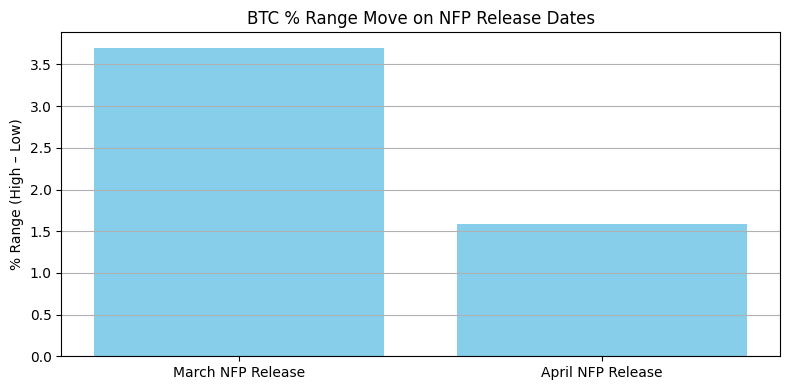

In [37]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define NFP dates
nfp_dates = {
    "2025-04-04": "March NFP Release",
    "2025-05-02": "April NFP Release"
}

# Step 2: Download BTC daily data with a buffer window
btc = yf.download("BTC-USD", start="2025-03-30", end="2025-05-05")
btc.reset_index(inplace=True)

# Step 3: Flatten columns if needed (MultiIndex safety)
if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

# Step 4: Match each NFP release to nearest BTC market day
results = []
for nfp_date_str, label in nfp_dates.items():
    nfp_dt = pd.to_datetime(nfp_date_str)
    idx = (btc['Date'] - nfp_dt).abs().idxmin()
    row = btc.loc[idx]

    results.append({
        'NFP Release Date': nfp_date_str,
        'Nearest Market Date': row['Date'].strftime('%Y-%m-%d'),
        'Open': round(row['Open'], 2),
        'High': round(row['High'], 2),
        'Low': round(row['Low'], 2),
        'Close': round(row['Close'], 2),
        '% Range Move': round((row['High'] - row['Low']) / row['Low'] * 100, 2),
        '% Open-Close Move': round((row['Close'] - row['Open']) / row['Open'] * 100, 2),
        'Event': label
    })

# Step 5: Create DataFrame
btc_nfp_data = pd.DataFrame(results)
print(btc_nfp_data)

# Step 6: Plot % range move as bar chart
plt.figure(figsize=(8, 4))
plt.bar(btc_nfp_data['Event'], btc_nfp_data['% Range Move'], color='skyblue')
plt.title('BTC % Range Move on NFP Release Dates')
plt.ylabel('% Range (High – Low)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


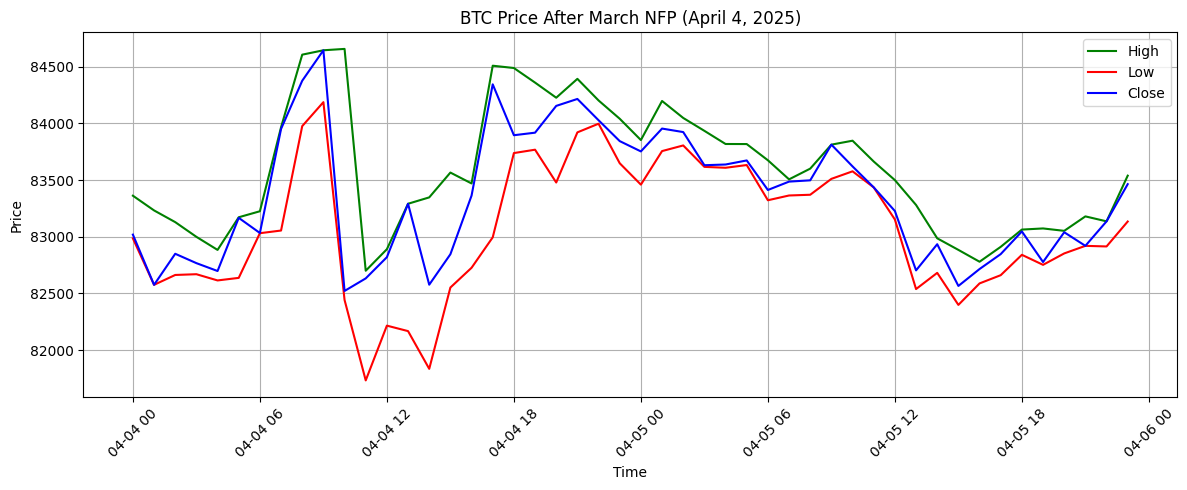

In [39]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download hourly BTC data around NFP release dates
btc_24h_april = yf.download("BTC-USD", start="2025-04-04", end="2025-04-06", interval="1h")
btc_24h_may = yf.download("BTC-USD", start="2025-05-02", end="2025-05-04", interval="1h")

# Plot April
plt.figure(figsize=(12, 5))
plt.plot(btc_24h_april.index, btc_24h_april['High'], label='High', color='green')
plt.plot(btc_24h_april.index, btc_24h_april['Low'], label='Low', color='red')
plt.plot(btc_24h_april.index, btc_24h_april['Close'], label='Close', color='blue')
plt.title('BTC Price After March NFP (April 4, 2025)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



[*********************100%***********************]  1 of 1 completed


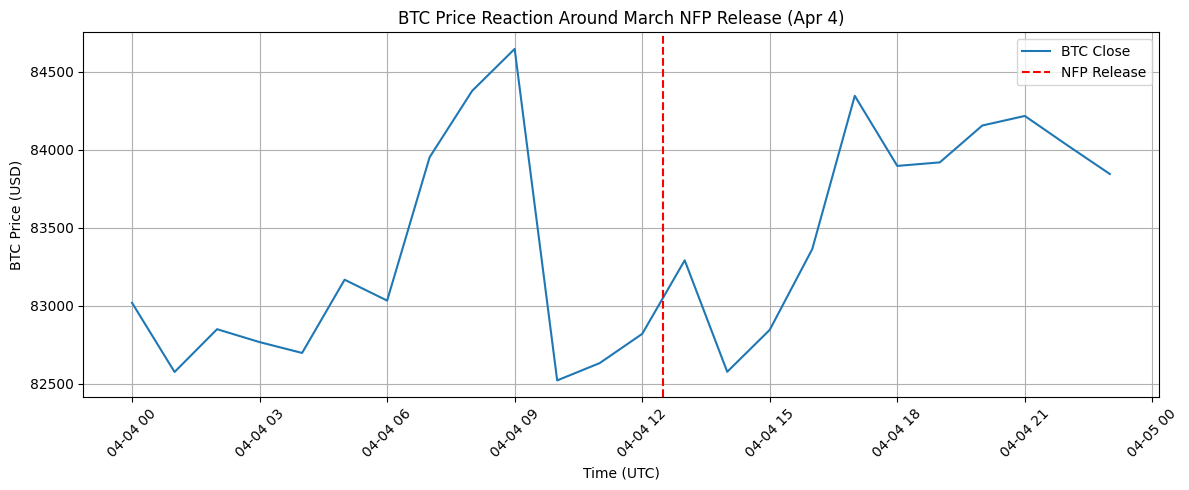

[*********************100%***********************]  1 of 1 completed


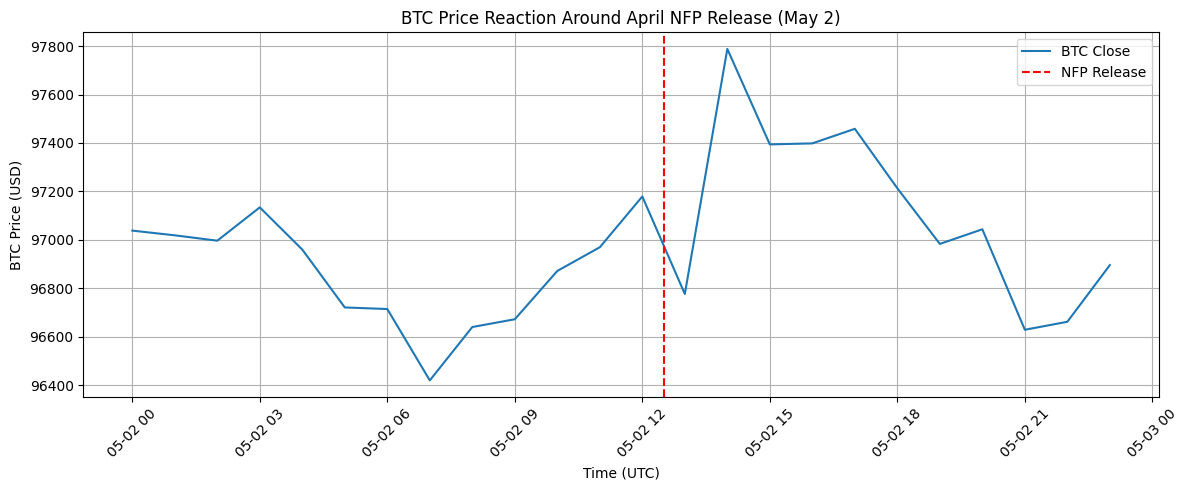

In [40]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

nfp_releases = {
    "March NFP Release (Apr 4)": datetime(2025, 4, 4, 12, 30),
    "April NFP Release (May 2)": datetime(2025, 5, 2, 12, 30),
}

for label, release_time in nfp_releases.items():
    start = release_time - timedelta(hours=2)
    end = release_time + timedelta(hours=24)

    btc = yf.download("BTC-USD", start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), interval="1h")

    plt.figure(figsize=(12, 5))
    plt.plot(btc.index, btc['Close'], label='BTC Close')
    plt.axvline(release_time, color='red', linestyle='--', label='NFP Release')
    plt.title(f"BTC Price Reaction Around {label}")
    plt.xlabel("Time (UTC)")
    plt.ylabel("BTC Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
